In [1]:
import errno
import time

import math
import numpy as np
import pandas as pd

import torch
import pyro

from spexlvm.data import load_dataset

from spexlvm.data import Pathways
from spexlvm.data import load_pathways
from spexlvm.models import SparseFactorAnalysis
from spexlvm.callbacks import EarlyStoppingCallback


In [2]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_context("notebook")

Using matplotlib backend: agg


In [3]:
from spexlvm.utils import get_free_gpu_idx
try:
    gpu_idx = get_free_gpu_idx()
    print("Using GPU:%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)


Using GPU:0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
use_cuda = str(device) == 'cuda'

cuda


In [5]:
# setup dataset
dataset = "mesc"
subsample_size = 0
n_top_genes = 6000

# setup gene set pathways
pathways = ['hallmark', 'reactome']
pathway_gene_fraction = [0.3, 0.3]
pathway_min_gene_count = [20, 50]

n_sparse = 0
n_dense = 1
scale_confidence = 0.99

# setup training parameters
batch_size = 0
center = True


In [6]:
# load data
Y, labels, batch = load_dataset(
    dataset, subsample_size=subsample_size, n_top_genes=n_top_genes, center=center
)

print("Loaded dataset of shape (%s, %s)" %(Y.shape[0], Y.shape[1]))

Y_train = torch.from_numpy(Y.values).float()

2021-07-16 14:38:34 - INFO - Using 6000 most variable genes
Loaded dataset of shape (182, 6000)


In [7]:
# load pathways
gene_sets = tuple()
for i, p in enumerate(pathways):
    print(
        "Loading pathway %s with at least %s of genes available and at least %s genes" % (
        p,
        pathway_gene_fraction[i] * 100,
        pathway_min_gene_count[i],
        )
    )
    tmp_gene_sets = (
        load_pathways(keep=[p])
        .subset(
            Y.columns,
            fraction_available=pathway_gene_fraction[i],
            min_gene_count=pathway_min_gene_count[i],
            max_gene_count=275,
        )
        .gene_sets
    )
    gene_sets += tmp_gene_sets

    print("Adding %s pathways from %s collection" % (len(tmp_gene_sets), p))

measured_pathways = Pathways(gene_sets=gene_sets)
redundant_pathways = []
for k, v in measured_pathways.find_redundant().items():
    redundant_pathways += v[1:]

print(
    "Removing following redundant pathways %s" % ", ".join(redundant_pathways)
)
measured_pathways = measured_pathways.remove(redundant_pathways)
assert len(measured_pathways.find_redundant()) == 0
# print(measured_pathways.info(verbose=1))
print("Loaded in total %s pathways" % len(measured_pathways))


Loading pathway hallmark with at least 30.0 of genes available and at least 20 genes
Adding 29 pathways from hallmark collection
Loading pathway reactome with at least 30.0 of genes available and at least 50 genes
Adding 53 pathways from reactome collection
Removing following redundant pathways 
Loaded in total 82 pathways


In [8]:
pathway_mask, gene_sets_list = measured_pathways.to_mask(Y.columns, sort=True)

n_annotated = len(measured_pathways)
n_factors = n_sparse + n_annotated + n_dense

print("Adding %s sparse and %s dense factors for a total of %s factors" % (n_sparse, n_dense, n_factors))

local_on_scale = 1.0

local_prior_scales = torch.cat(
    [
        (1 - scale_confidence) * torch.ones(n_sparse, Y.shape[1]),
        # torch.zeros(n_sparse, Y.shape[1]),
        local_on_scale * pathway_mask,
        local_on_scale * torch.ones(n_dense, Y.shape[1]),
    ]
)
local_prior_scales += 1 - scale_confidence


Adding 0 sparse and 1 dense factors for a total of 83 factors


In [9]:
# setup gpu
print("Use GPU: %s" % use_cuda)
if use_cuda:
    if batch_size == 0 or batch_size == Y_train.shape[0]:
        Y_train = Y_train.cuda()
    local_prior_scales = local_prior_scales.cuda()
    torch.set_default_tensor_type("torch.cuda.FloatTensor")


Use GPU: True


In [10]:
# create pathway guided sparse model
model = SparseFactorAnalysis(
    n_features=Y.shape[1],
    n_factors=n_factors,
    global_prior_scale=0.1,
    local_prior_scales=local_prior_scales,
    use_cuda=use_cuda,
)


In [11]:
# set random seed
pyro.set_rng_seed(17062021)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

Cleaning parameter store


In [12]:
n_iterations = 50000
loss_history = model.fit(
    Y_train,
    learning_rate=0.0005,
    batch_size=batch_size,
    n_iterations=n_iterations,
    verbose=1,
    callbacks=[EarlyStoppingCallback(n_iterations, min_iterations=1000, window_size=10, tolerance=1e-4, patience=10)],
)

2021-07-16 14:38:37 - INFO - Using complete dataset
 50%|█████     | 25180/50000 [16:54<16:39, 24.83it/s, ELBO=4.23e+3]


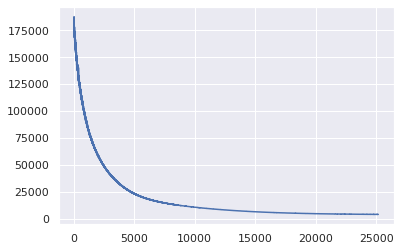

In [13]:
plt.plot(loss_history)

In [14]:

Y_train = Y_train.cpu().detach().numpy()
W = model.W.cpu().detach().numpy()
X = model.X.cpu().detach().numpy()
pathway_mask = pathway_mask.cpu().detach().numpy()
local_prior_scales = local_prior_scales.cpu().detach().numpy()


In [15]:
from spexlvm.utils import compute_factor_relevance

def scatterplot(df, title, x, y, figsize = None, **kwargs):
    if figsize is None:
        figsize = (16, 10)
    plt.figure(figsize=figsize)
    g = sns.scatterplot(data=df, x=x, y=y, **kwargs)
    g.set_title(title)
    return g

black = "#000000"
red = "#e24a33"
color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


In [16]:
print("Computing factor relevance (R2)")
factors_df = compute_factor_relevance(Y_train, X, W)

Computing factor relevance (R2)
100%|██████████| 83/83 [00:01<00:00, 47.83it/s]


In [17]:

gene_sets_name_list = (
    ["SPARSE_%s" % i for i in range(n_sparse)]
    + [gs.name for gs in gene_sets_list]
    + ["DENSE_%s" % i for i in range(n_dense)]
)

# prettify names
def prettify_gene_set_name(gene_set_name, str_len_threshold=30):
    gsn_parts = [part.capitalize() for part in gene_set_name.split('_')]
    if gsn_parts[0] not in ["Sparse", "Dense"]:
        gsn_parts[0] = "(" + gsn_parts[0][0] + ")"
        gsn_parts = gsn_parts[1:] + gsn_parts[:1]
    
    new_gene_set_name = ' '.join(gsn_parts)
    if len(new_gene_set_name) > str_len_threshold:
        half_str_len_threshold = (str_len_threshold - 4) // 2
        new_gene_set_name = new_gene_set_name[:half_str_len_threshold] + "..." + new_gene_set_name[-half_str_len_threshold-3:]
    
    return new_gene_set_name

gene_sets_name_list = [prettify_gene_set_name(gsn) for gsn in gene_sets_name_list]
factors_df["Factor"] = [gene_sets_name_list[i] for i in factors_df["Index"]]


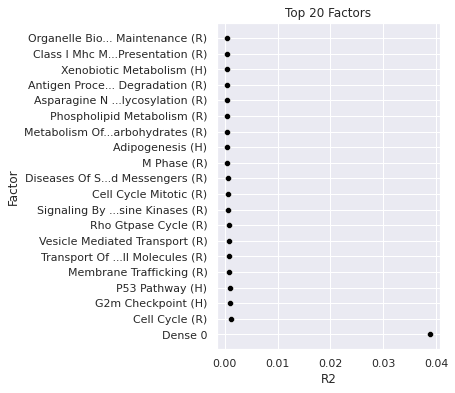

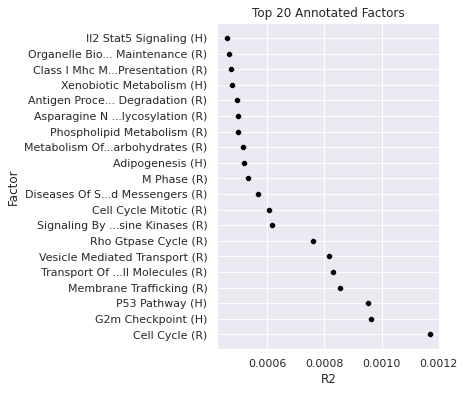

In [18]:
x = "R2"
y = "Factor"
top_k = 20
sorted_factors_df = factors_df.sort_values([x], ascending=True)
scatterplot(
    sorted_factors_df.iloc[-top_k:], 
    title=f"Top {top_k} Factors", 
    x=x, 
    y=y, 
    figsize=(4, 6),
    color=black
    )
plt.show()
scatterplot(
    sorted_factors_df[~(sorted_factors_df[y].str.lower().str.contains("sparse|dense"))].iloc[-top_k:], 
    title=f"Top {top_k} Annotated Factors", 
    x=x, 
    y=y, 
    figsize=(4, 6),
    color=black
    )
plt.show()



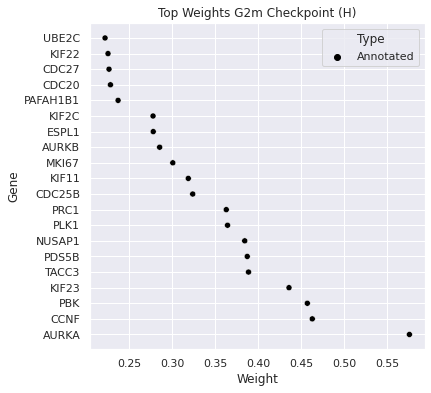

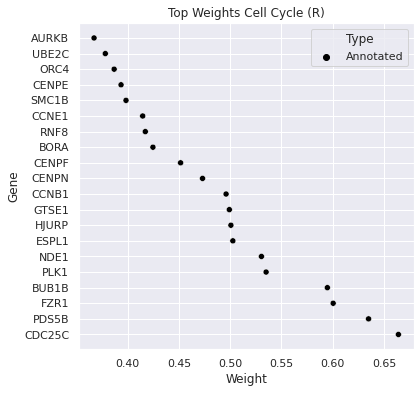

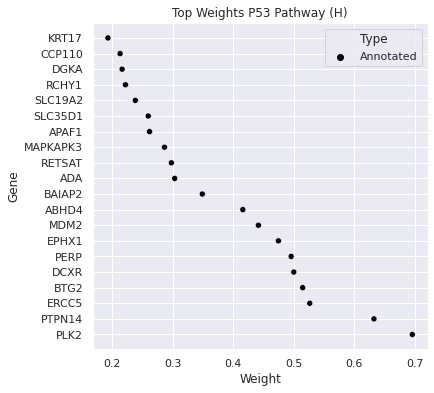

In [19]:
# inspect weights of relevant factors
relevant_gene_sets = ["HALLMARK_G2M_CHECKPOINT", "REACTOME_CELL_CYCLE", "HALLMARK_P53_PATHWAY"]
relevant_gene_sets = [prettify_gene_set_name(relevant_gs) for relevant_gs in relevant_gene_sets]

relevant_factors_dict = {}
factor_weights_threshold = 0.1
for relevant_gs in relevant_gene_sets:
    relevant_gs_idx = gene_sets_name_list.index(relevant_gs)
    relevant_factor_df = sorted_factors_df.loc[relevant_gs_idx, :]
    factor_idx = relevant_factor_df["Index"]
    factor_name = relevant_factor_df["Factor"]
    factor_weights = np.abs(W[factor_idx, :])
    factor_mask = local_prior_scales[factor_idx, :]
    tmp_df = pd.DataFrame(
        {
            "Index": factor_idx,
            "Factor": factor_name,
            "Weight": factor_weights,
            "Gene": Y.columns[: len(factor_mask)],
            "Mask": factor_mask,
            "FP": (factor_mask < local_on_scale)
            & (factor_weights >= factor_weights_threshold),
            "FN": (factor_mask >= local_on_scale)
            & (factor_weights < factor_weights_threshold),
        }
    )
    tmp_df["Type"] = "Annotated"
    tmp_df.loc[tmp_df["FP"], "Type"] = "Inferred"
    relevant_factors_dict[factor_name] = tmp_df
    scatterplot(
            tmp_df.sort_values(["Weight"], ascending=True).iloc[-20:],
            title="Top Weights " + factor_name,
            x="Weight",
            y="Gene",
            figsize=(6, 6),
            hue="Type",
            palette={"Annotated": black, "Inferred": red},
        )
    plt.show()


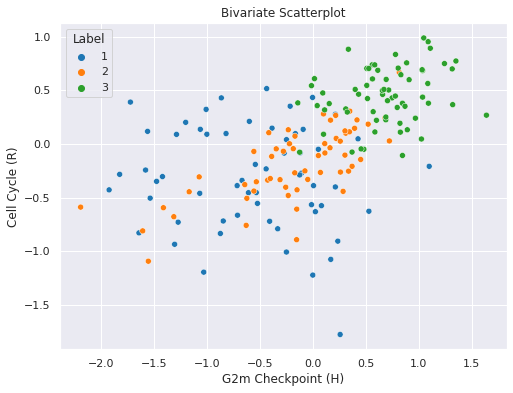

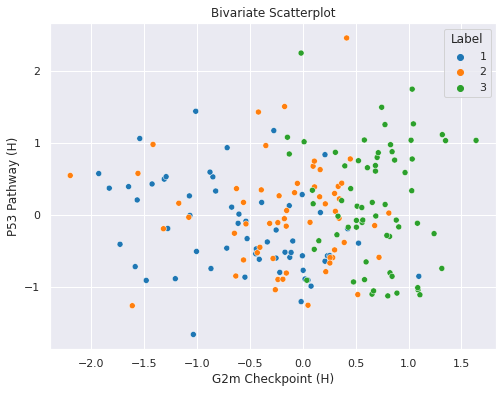

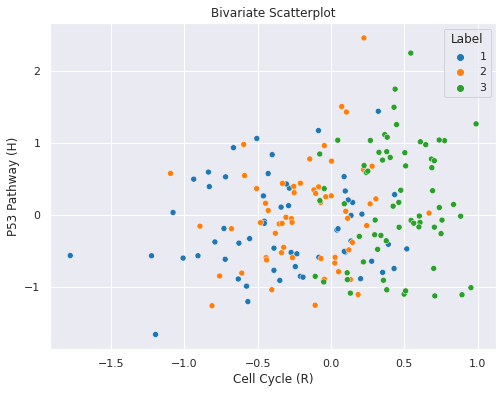

In [20]:
Y["Label"] = labels

for gsn, fdf in relevant_factors_dict.items():
    Y[gsn] = X[:, fdf["Index"].iloc[0]]

for i in range(len(relevant_gene_sets) - 1):
    for j in range(i + 1, len(relevant_gene_sets)):

        x = relevant_gene_sets[i]
        y = relevant_gene_sets[j]

        scatterplot(
            Y,
            title="Bivariate Scatterplot",
            x=x,
            y=y,
            figsize=(8, 6),
            hue="Label",
            palette=color_palette[:3],
            )
        plt.show()